Prepare data for DBSCAN 

In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan 
from sklearn.cluster import DBSCAN

In [35]:
# read data from csv file
fake_transaction = pd.read_csv('fake_transactional_data_24.csv')

In [36]:
fake_transaction.head()

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,88339.0,2.40,40544,01/01/2025
2,18555.0,2.40,85149,01/01/2025
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
4,80792.0,1.95,18555,01/01/2025


Generate summary statistics

In [37]:
fake_transaction.describe()

,from_totally_fake_account,monopoly_money_amount
count,1.014828e+07,1.014828e+07
mean,5.080502e+04,1.839348e+01
std,2.893710e+04,8.612323e+01
min,1.000000e+03,1.450000e+00
25%,2.530400e+04,2.650000e+00
50%,5.078100e+04,6.000000e+00
75%,7.563300e+04,1.200000e+01
max,1.009880e+05,1.995000e+03


In [38]:
fake_transaction.columns

Index(['from_totally_fake_account', 'monopoly_money_amount',
       'to_randomly_generated_account', 'not_happened_yet_date'],
      dtype='object')

count Null values

In [39]:
nanCount = fake_transaction.isnull().sum()
nanCount


from_totally_fake_account        0
monopoly_money_amount            0
to_randomly_generated_account    0
not_happened_yet_date            0
dtype: int64

Check correlation of features

In [40]:
from scipy.stats import pearsonr

# Selecting only numeric columns
numeric_columns = fake_transaction.select_dtypes(include=[np.number]).columns

# Creating an empty DataFrame for the correlation matrix
correlationMatrix = pd.DataFrame(index=numeric_columns, columns=numeric_columns)

# Calculating Pearson correlation coefficient for each pair of columns
for i in numeric_columns:
    for j in numeric_columns:
        correlationMatrix.loc[i, j] = np.round(pearsonr(fake_transaction[i], fake_transaction[j])[0], 2)
print(correlationMatrix)


                          from_totally_fake_account monopoly_money_amount
from_totally_fake_account                       1.0                   0.0
monopoly_money_amount                           0.0                   1.0


both correlation coefficients are 0 between the 2 variables, so there is no linear relationship between them

## Identify non-numerical values by feature

In [41]:
fake_transaction

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,88339.0,2.40,40544,01/01/2025
2,18555.0,2.40,85149,01/01/2025
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
4,80792.0,1.95,18555,01/01/2025
...,...,...,...,...
10148275,32185.0,2.65,COFFEE_SHOP,31/12/2025
10148276,32185.0,2.45,COFFEE_SHOP,31/12/2025
10148277,57569.0,14.00,WINE_BAR,31/12/2025
10148278,1490.0,9.00,57569,31/12/2025


In [42]:
for i, val in enumerate(fake_transaction['to_randomly_generated_account']):
    # check value is numeric?
    if str(val).isnumeric():
        # replace numeric with NaN
        fake_transaction.at[i, 'to_randomly_generated_account'] = pd.NA

# drop rows where 'to_randomly_generated_account' is NaN
fake_transaction.dropna(subset=['to_randomly_generated_account'], inplace=True)

fake_transaction.reset_index(drop=True, inplace=True)

# show only people spend on business account
print(fake_transaction)

         from_totally_fake_account  monopoly_money_amount  \
0                          10371.0                   4.00   
1                          18555.0                   4.10   
2                          18555.0                   4.45   
3                          18555.0                   1.45   
4                          18555.0                   5.00   
...                            ...                    ...   
7615512                    81404.0                   1.80   
7615513                    32185.0                   2.65   
7615514                    32185.0                   2.45   
7615515                    57569.0                  14.00   
7615516                    53444.0                   2.65   

        to_randomly_generated_account not_happened_yet_date  
0                              CINEMA            01/01/2025  
1                 HIPSTER_COFFEE_SHOP            01/01/2025  
2          TOTALLY_A_REAL_COFFEE_SHOP            01/01/2025  
3                  

# Feature 1 using All business

In [43]:
feature_1 = fake_transaction.pivot_table(index='from_totally_fake_account',
                                columns='to_randomly_generated_account',
                                values='monopoly_money_amount',
                                aggfunc='mean')
#feature_1.reset_index(drop=True, inplace=True)
feature_1.reset_index(inplace=True)

feature_1

to_randomly_generated_account,from_totally_fake_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,1000.0,NaN,2.397845,2.301282,108.930000,11.812500,NaN,NaN,NaN,3.900000,...,NaN,27.500,NaN,NaN,52.000000,13.18,11.475000,NaN,11.458333,52.490
1,1002.0,NaN,2.328302,2.378261,96.796000,11.672727,NaN,NaN,NaN,5.000000,...,NaN,NaN,113.0,NaN,41.285714,41.36,12.166667,49.990,NaN,52.490
2,1006.0,NaN,2.359322,2.327372,20.824375,11.600962,NaN,21.474237,21.8,3.666667,...,55.571429,NaN,NaN,NaN,42.750000,NaN,13.500000,14.490,NaN,49.990
3,1018.0,NaN,NaN,2.037500,18.994000,7.118182,NaN,21.521739,26.0,3.666667,...,NaN,NaN,NaN,NaN,NaN,14.09,1.500000,29.990,1.500000,10.000
4,1053.0,NaN,2.245455,2.554545,93.366667,11.734694,NaN,NaN,18.0,4.122222,...,NaN,41.590,NaN,NaN,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,100931.0,NaN,2.297656,2.275385,19.745000,11.082278,NaN,23.925098,NaN,4.285714,...,81.000000,13.865,90.0,NaN,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,100934.0,NaN,2.344340,2.486275,87.778182,12.397196,20.000000,NaN,NaN,4.166667,...,NaN,15.910,NaN,NaN,NaN,NaN,11.769231,42.495,12.500000,NaN
8139,100947.0,NaN,2.295000,2.256481,100.068947,11.292000,11.333333,NaN,27.0,4.063830,...,NaN,21.820,90.0,NaN,24.000000,NaN,11.750000,19.990,12.062500,8.990
8140,100986.0,NaN,2.316667,2.650000,84.798571,11.344037,NaN,NaN,NaN,4.666667,...,NaN,15.450,38.0,NaN,22.000000,NaN,11.875000,24.990,11.857143,21.660


Some cell has NaN where people have not spent money so, I will replace these values with 0.

In [44]:
# replace NaN with 0
feature_1 = feature_1.fillna(0)
feature_1.head(10)

to_randomly_generated_account,from_totally_fake_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,1000.0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.000000,3.900000,...,0.000000,27.50,0.0,0.0,52.000000,13.18,11.475000,0.000000,11.458333,52.49
1,1002.0,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.00,113.0,0.0,41.285714,41.36,12.166667,49.990000,0.000000,52.49
2,1006.0,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.800000,3.666667,...,55.571429,0.00,0.0,0.0,42.750000,0.00,13.500000,14.490000,0.000000,49.99
3,1018.0,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.000000,3.666667,...,0.000000,0.00,0.0,0.0,0.000000,14.09,1.500000,29.990000,1.500000,10.00
4,1053.0,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.000000,4.122222,...,0.000000,41.59,0.0,0.0,43.000000,10.45,12.071429,29.990000,14.555556,74.99
5,1059.0,0.0,2.298889,2.298750,57.418000,11.176829,0.000000,0.000000,0.000000,4.928571,...,51.250000,34.09,0.0,0.0,43.000000,23.18,0.000000,10.000000,0.000000,0.00
6,1071.0,0.0,2.383636,2.413208,105.875000,6.709402,0.000000,0.000000,30.000000,4.625000,...,0.000000,45.45,81.5,0.0,42.000000,0.00,1.500000,26.656667,1.500000,29.99
7,1078.0,0.0,2.406154,2.337273,94.731111,12.091549,0.000000,0.000000,15.923077,4.500000,...,44.250000,39.09,0.0,0.0,60.000000,0.00,10.500000,9.000000,12.500000,0.00
8,1086.0,0.0,2.338596,2.441304,25.117500,5.737410,0.000000,22.218182,0.000000,5.000000,...,36.250000,34.55,117.0,0.0,41.000000,0.00,1.500000,74.990000,1.500000,41.99
9,1087.0,0.0,2.413986,2.406923,0.000000,11.515385,6.666667,0.000000,0.000000,5.250000,...,0.000000,24.55,0.0,0.0,43.000000,8.18,12.487500,0.000000,12.761905,29.99


In [45]:
# get all column names
feature_1.columns

Index(['from_totally_fake_account', 'ACCESSORY_SHOP', 'A_CAFE',
       'A_LOCAL_COFFEE_SHOP', 'A_SUPERMARKET', 'BAR', 'BOOKSHOP', 'BUTCHER',
       'BUTCHERS', 'CAFE', 'CHILDRENDS_SHOP', 'CHINESE_RESTAURANT',
       'CHINESE_TAKEAWAY', 'CINEMA', 'CLOTHES_SHOP', 'COCKTAIL_BAR',
       'COFFEE_SHOP', 'COMIC_BOOK_SHOP', 'COOKSHOP', 'DEPARTMENT_STORE',
       'DIY_STORE', 'DVD_SHOP', 'ELECTRONICS_SHOP', 'EXPRESS_SUPERMARKET',
       'FASHIONABLE_SPORTSWARE_SHOP', 'FASHION_SHOP', 'FLORIST', 'G&T_BAR',
       'GAME_SHOP', 'GOURMET_COFFEE_SHOP', 'GREENGROCER', 'GYM',
       'HIPSTER_COFFEE_SHOP', 'HIPSTER_ELECTRONICS_SHOP',
       'HOME_IMPROVEMENT_STORE', 'INDIAN_RESTAURANT', 'JEWLLERY_SHOP',
       'KEBAB_SHOP', 'KIDS_ACTIVITY_CENTRE', 'KIDS_CLOTHING_SHOP',
       'LARGE_SUPERMARKET', 'LIQUOR_STORE', 'LOCAL_BOOKSHOP', 'LOCAL_PUB',
       'LOCAL_RESTAURANT', 'LOCAL_WATERING_HOLE', 'LUNCH_PLACE', 'LUNCH_VAN',
       'NERDY_BOOK_STORE', 'PET_SHOP', 'PET_TOY_SHOP',
       'PRETENTIOUS_COFFEE_SH

In [46]:
# drop the 1st column because it is index value
feature_1 = feature_1.drop(columns=['from_totally_fake_account'])
feature_1

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.0,3.900000,0.000000,...,0.000000,27.500,0.0,0.0,52.000000,13.18,11.475000,0.000,11.458333,52.490
1,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.0,5.000000,0.000000,...,0.000000,0.000,113.0,0.0,41.285714,41.36,12.166667,49.990,0.000000,52.490
2,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.8,3.666667,0.000000,...,55.571429,0.000,0.0,0.0,42.750000,0.00,13.500000,14.490,0.000000,49.990
3,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.0,3.666667,59.000000,...,0.000000,0.000,0.0,0.0,0.000000,14.09,1.500000,29.990,1.500000,10.000
4,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.0,4.122222,20.000000,...,0.000000,41.590,0.0,0.0,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,2.297656,2.275385,19.745000,11.082278,0.000000,23.925098,0.0,4.285714,0.000000,...,81.000000,13.865,90.0,0.0,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,0.0,2.344340,2.486275,87.778182,12.397196,20.000000,0.000000,0.0,4.166667,0.000000,...,0.000000,15.910,0.0,0.0,0.000000,0.00,11.769231,42.495,12.500000,0.000
8139,0.0,2.295000,2.256481,100.068947,11.292000,11.333333,0.000000,27.0,4.063830,78.000000,...,0.000000,21.820,90.0,0.0,24.000000,0.00,11.750000,19.990,12.062500,8.990
8140,0.0,2.316667,2.650000,84.798571,11.344037,0.000000,0.000000,0.0,4.666667,0.000000,...,0.000000,15.450,38.0,0.0,22.000000,0.00,11.875000,24.990,11.857143,21.660


In [47]:
# find the number of row and column
feature_1.shape

(8142, 79)

We have 79 column (from 79 businesses)

In [48]:
# get some statistic values from dataset
feature_1.describe()

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,...,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,1.012107,2.294299,2.296651,73.675676,11.227719,4.834824,4.999299,11.094166,4.191598,25.622156,...,25.904852,17.470078,14.556565,12.070744,25.221249,17.667536,9.706077,17.136904,9.747617,16.973205
std,4.721198,0.463676,0.451919,33.113623,1.554503,6.419806,9.372035,16.039906,1.095605,29.831505,...,30.212803,16.059297,31.181266,24.260434,20.491648,16.060775,4.658766,19.483967,4.604825,19.591090
min,0.000000,0.000000,0.000000,0.000000,3.433673,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.315179,2.316182,52.282115,11.209343,0.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.289167,0.000000,10.357143,0.000000
50%,0.000000,2.392991,2.391564,83.930556,11.707239,0.000000,0.000000,0.000000,4.377551,0.000000,...,0.000000,17.270000,0.000000,0.000000,34.000000,17.993750,11.516146,10.262000,11.500000,10.000000
75%,0.000000,2.455378,2.451671,97.431500,12.041667,11.812500,0.000000,18.333333,4.666667,53.600000,...,54.364583,30.910000,0.000000,0.000000,42.000000,30.910000,12.314683,24.990000,12.333333,24.990000
max,31.750000,2.847778,2.837838,149.780000,13.500000,20.000000,27.249024,75.000000,6.000000,100.000000,...,100.000000,50.000000,120.000000,75.000000,60.000000,50.000000,18.000000,74.990000,18.000000,74.990000


In [49]:
feature_1

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.0,3.900000,0.000000,...,0.000000,27.500,0.0,0.0,52.000000,13.18,11.475000,0.000,11.458333,52.490
1,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.0,5.000000,0.000000,...,0.000000,0.000,113.0,0.0,41.285714,41.36,12.166667,49.990,0.000000,52.490
2,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.8,3.666667,0.000000,...,55.571429,0.000,0.0,0.0,42.750000,0.00,13.500000,14.490,0.000000,49.990
3,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.0,3.666667,59.000000,...,0.000000,0.000,0.0,0.0,0.000000,14.09,1.500000,29.990,1.500000,10.000
4,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.0,4.122222,20.000000,...,0.000000,41.590,0.0,0.0,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,2.297656,2.275385,19.745000,11.082278,0.000000,23.925098,0.0,4.285714,0.000000,...,81.000000,13.865,90.0,0.0,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,0.0,2.344340,2.486275,87.778182,12.397196,20.000000,0.000000,0.0,4.166667,0.000000,...,0.000000,15.910,0.0,0.0,0.000000,0.00,11.769231,42.495,12.500000,0.000
8139,0.0,2.295000,2.256481,100.068947,11.292000,11.333333,0.000000,27.0,4.063830,78.000000,...,0.000000,21.820,90.0,0.0,24.000000,0.00,11.750000,19.990,12.062500,8.990
8140,0.0,2.316667,2.650000,84.798571,11.344037,0.000000,0.000000,0.0,4.666667,0.000000,...,0.000000,15.450,38.0,0.0,22.000000,0.00,11.875000,24.990,11.857143,21.660


In [50]:
# split the data
X_train, X_test = train_test_split(feature_1, test_size=0.2, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

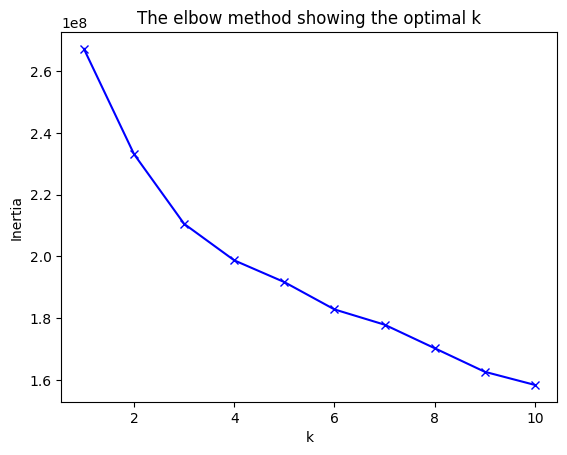

In [51]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')




In [52]:
# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.13719070948038112


Silhouette Score: 0.1716359787871223
Number of clusters identified: 3


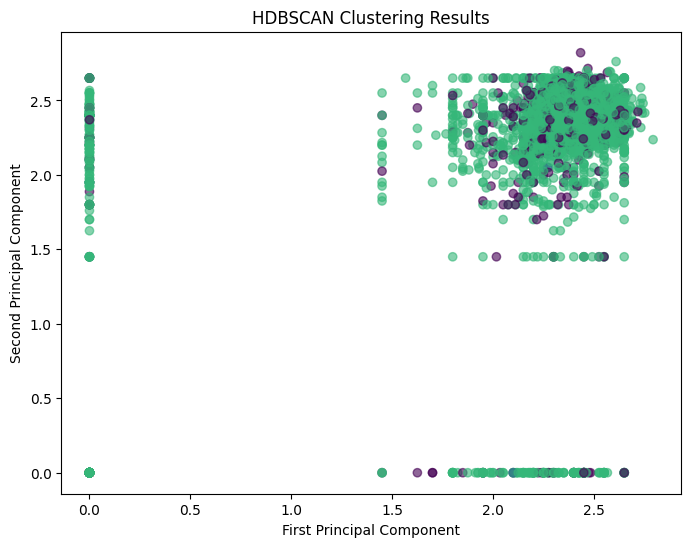

In [53]:
# initialize HDBSCAN with default parameters --> I will try to do more with changing parameter
clusterer = hdbscan.HDBSCAN()

# fit he model
clusterer.fit(X_train)

# predict clusters for the test data
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

num_clusters = len(np.unique(clusterer.labels_)) - 1  # -1 because I want to exclude noise points
print("Number of clusters identified:", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 1], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



In [54]:
# reset index
X_train.reset_index(inplace=True)


# Feature 2 with all business but with PCA

In [55]:
feature_2 = feature_1
feature_2

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.0,3.900000,0.000000,...,0.000000,27.500,0.0,0.0,52.000000,13.18,11.475000,0.000,11.458333,52.490
1,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.0,5.000000,0.000000,...,0.000000,0.000,113.0,0.0,41.285714,41.36,12.166667,49.990,0.000000,52.490
2,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.8,3.666667,0.000000,...,55.571429,0.000,0.0,0.0,42.750000,0.00,13.500000,14.490,0.000000,49.990
3,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.0,3.666667,59.000000,...,0.000000,0.000,0.0,0.0,0.000000,14.09,1.500000,29.990,1.500000,10.000
4,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.0,4.122222,20.000000,...,0.000000,41.590,0.0,0.0,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,2.297656,2.275385,19.745000,11.082278,0.000000,23.925098,0.0,4.285714,0.000000,...,81.000000,13.865,90.0,0.0,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,0.0,2.344340,2.486275,87.778182,12.397196,20.000000,0.000000,0.0,4.166667,0.000000,...,0.000000,15.910,0.0,0.0,0.000000,0.00,11.769231,42.495,12.500000,0.000
8139,0.0,2.295000,2.256481,100.068947,11.292000,11.333333,0.000000,27.0,4.063830,78.000000,...,0.000000,21.820,90.0,0.0,24.000000,0.00,11.750000,19.990,12.062500,8.990
8140,0.0,2.316667,2.650000,84.798571,11.344037,0.000000,0.000000,0.0,4.666667,0.000000,...,0.000000,15.450,38.0,0.0,22.000000,0.00,11.875000,24.990,11.857143,21.660


### Principal Component Analysis

I will projects the data from the original 79-dimensional space to lower dimensional space.

In [56]:
n_components = 79
whiten = False # transformed data = scale as the original data
random_state = 10

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

In [57]:
X_train, X_test = train_test_split(feature_2, test_size=0.2, random_state=42)


In [58]:
X_train_PCA = pca.fit_transform(X_train)
train_index = range(0,len(X_train))
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,-112.880449,-19.215936,-3.452574,1.472758,-18.374606,80.311626,-19.408172,-8.335971,-0.701825,-0.566296,...,-1.110935,-1.944482,-0.712585,-0.278329,0.091778,-0.395764,0.366173,0.083776,0.060471,0.006062
1,35.664459,-30.490376,-44.449287,-88.603195,-41.223931,-44.419875,-31.674829,-9.792504,8.637048,-9.302514,...,-0.161803,0.013055,-0.316301,-0.129015,-0.095076,-0.144527,-0.168074,-0.071340,0.095456,-0.064847
2,91.549078,-41.136885,-26.534419,36.359808,6.635295,4.853488,-28.568524,7.085237,1.023816,-9.346308,...,0.281859,-1.075797,1.304179,-1.225384,-0.100521,-0.211311,-0.012215,0.083595,0.070890,0.170973
3,-44.628853,-30.364814,107.308052,85.864605,60.904224,-45.199530,6.680076,18.184526,-6.770345,-4.854399,...,-1.012428,-0.831857,-0.915965,-2.017228,-0.297042,-0.238919,-0.156667,-0.064572,0.216759,0.231916
4,87.564120,-43.363002,111.604040,-34.579980,-20.299181,1.695346,-28.083464,-7.303347,4.460805,-4.917218,...,0.467552,-0.129611,1.328129,0.558694,0.269287,-0.224510,-2.265030,0.113104,0.083414,0.045442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-109.731533,-16.852813,-57.120453,1.331959,-13.517669,56.515491,-21.339809,-4.295375,-0.095816,-0.952453,...,-1.162916,-0.314161,-1.023153,1.417187,0.157512,-0.321862,0.620371,0.166751,0.114211,0.012084
6509,-110.096582,-15.847329,-49.186776,-0.129408,6.560281,-8.020721,123.327548,-9.329005,-10.392982,82.468089,...,0.240443,-0.244541,0.401948,0.201578,0.059544,-0.038273,-0.095025,0.108539,-0.087664,0.119510
6510,84.472872,-6.739621,-20.707042,-111.476244,-70.082008,56.983674,18.805757,-33.037997,54.649674,-23.459763,...,2.179679,0.456903,-1.429859,-1.245671,0.742114,-0.078399,-0.970510,0.113334,0.112786,-0.136515
6511,-111.052589,-17.611523,-24.466136,2.355855,-13.283191,59.972455,-22.258203,-5.017626,1.740376,-20.242007,...,-0.380370,0.212735,-0.885847,-0.020408,0.047756,0.135388,-0.251825,-0.103114,0.017430,-0.002550


In [59]:
# percentage of Variance Captured by 79 principal components
print("Variance Explained by all 79 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 79 principal components:  1.0000000000000007


it retaining all the information present in the original data

In [60]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 30 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:29].sum(axis=1).values)
print('Variance Captured by First 40 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:40].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)


Variance Captured by First 10 Principal Components:  [0.73497463]
Variance Captured by First 20 Principal Components:  [0.86874745]
Variance Captured by First 30 Principal Components:  [0.94741216]
Variance Captured by First 40 Principal Components:  [0.98547342]
Variance Captured by First 50 Principal Components:  [0.99508629]


The first 10 components in total capture approximately 70% of the variance, the 30th components almost 95%, the 40th components almost 98.5%, and the 50th components almost 100% of the variance.

With just the first 30th principal components (far fewer than the original 79 dimensions), we capture almost 95% of the variance/information.

In [61]:
X_test_PCA = pca.transform(X_test)
X_test_PCA.shape

(1629, 79)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

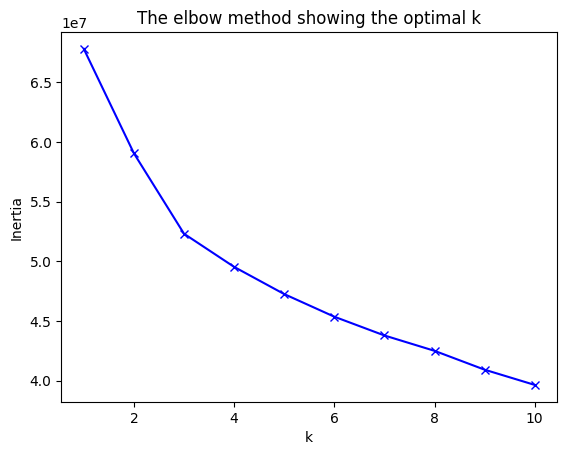

In [62]:
# fit PCA to the training data
pca = PCA(n_components=79, random_state=42)
X_train_PCA = pca.fit_transform(X_train)

# transform the test data using the same PCA object
X_test_PCA = pca.transform(X_test)

# loop over k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class
    kmeans = KMeans(n_clusters= k)
    
    # fit the model
    kmeans.fit(X_test_PCA)

    # append the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')




In [63]:
# apply K-means clustering to the reduced-dimensional features
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = kmeans.predict(X_test_PCA)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.1398865339493584


In [64]:
# apply K-means clustering to the reduced-dimensional features
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = kmeans.predict(X_test_PCA)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.12388848592768087


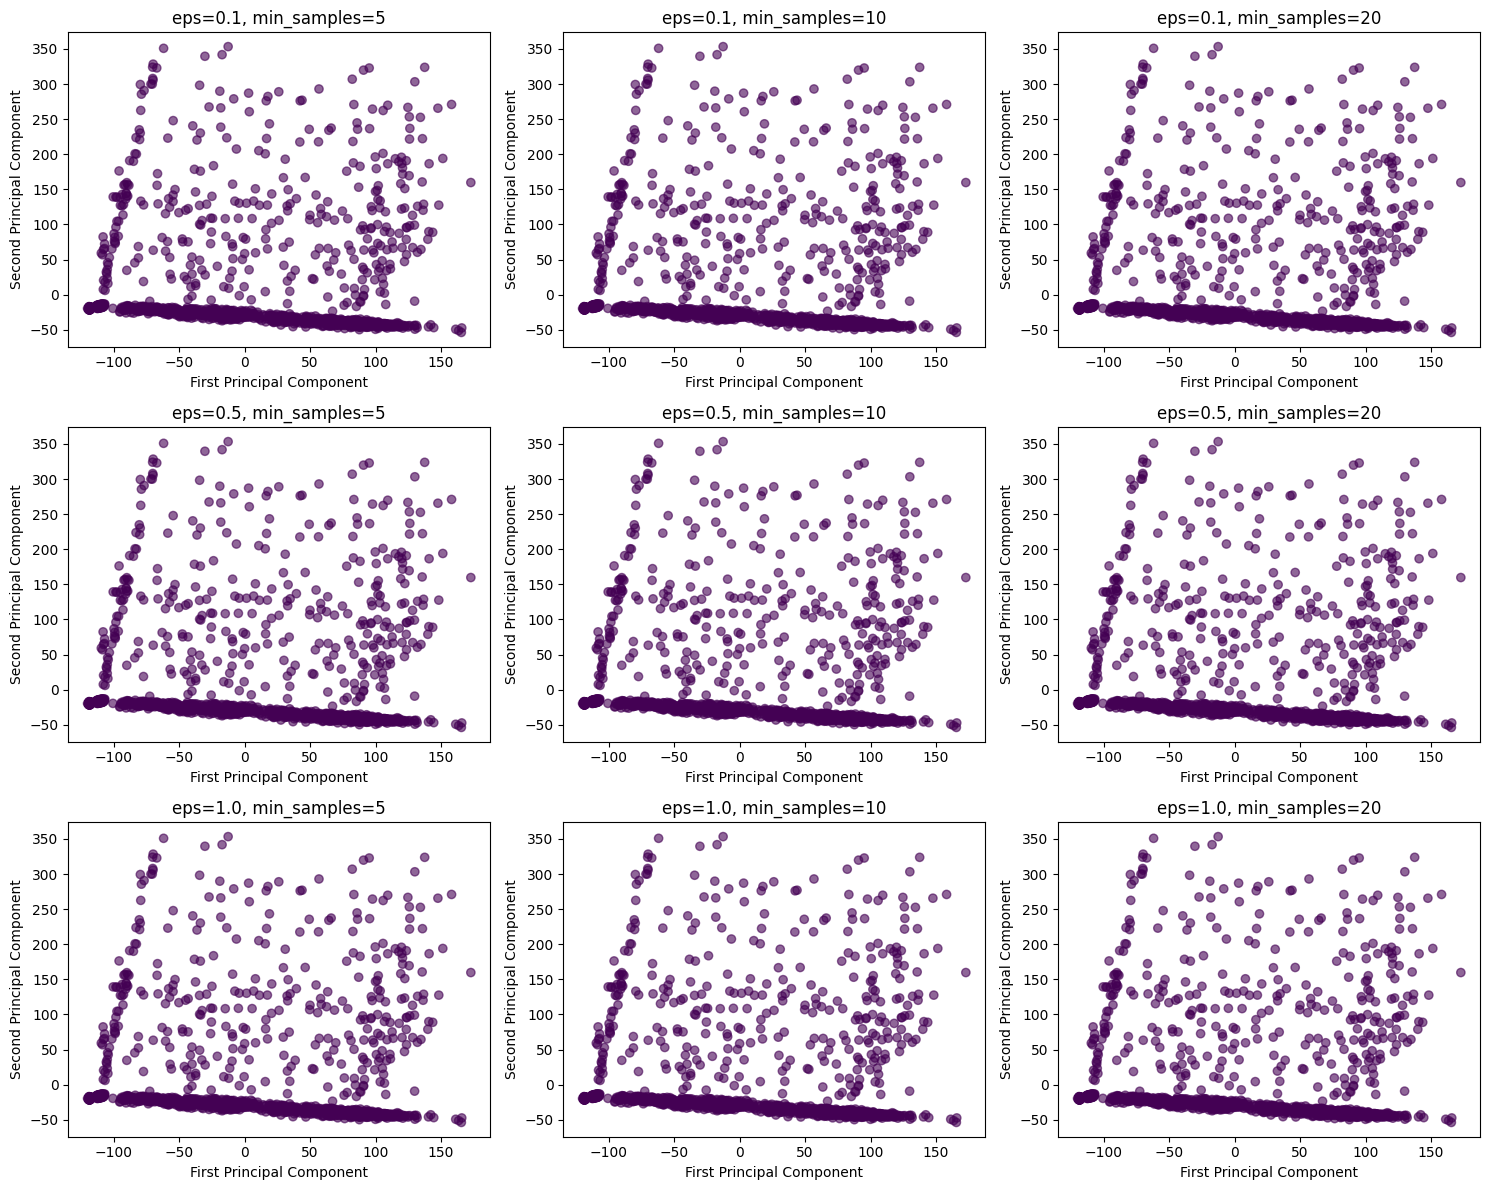

In [65]:
# initialize DBSCAN with different parameters
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 20]

fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 12))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # fit DBSCAN to the reduced-dimensional features
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        test_clusters = dbscan.fit_predict(X_test_PCA)

        axs[i, j].scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
        axs[i, j].set_title(f"eps={eps}, min_samples={min_samples}")
        axs[i, j].set_xlabel("First Principal Component")
        axs[i, j].set_ylabel("Second Principal Component")

plt.tight_layout()
plt.show()


In [66]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = clusterer.fit_predict(X_test_PCA)

# evaluate the clusters
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.13864960530757206


In [67]:
# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)


Number of clusters identified: 2


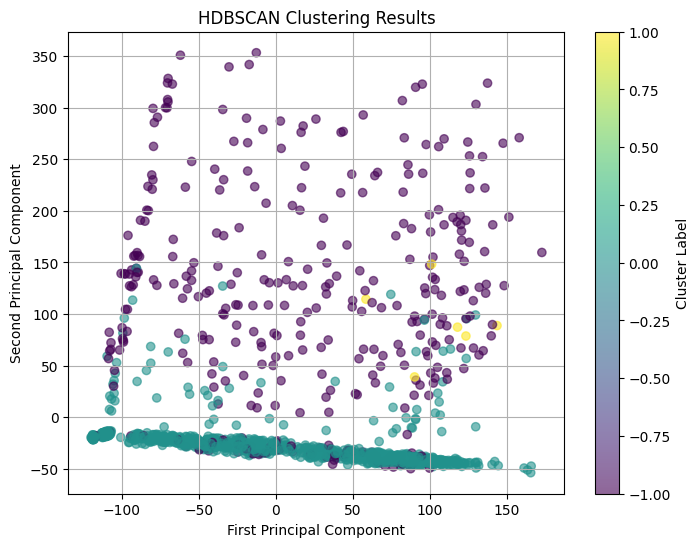

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


# Feature 3 top 3 and 6 spending
Find only amount in spending top 3 and 6 to see potential money spending (social status group)

In [69]:
fake_transaction

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
2,18555.0,4.45,TOTALLY_A_REAL_COFFEE_SHOP,01/01/2025
3,18555.0,1.45,COFFEE_SHOP,01/01/2025
4,18555.0,5.00,CAFE,01/01/2025
...,...,...,...,...
7615512,81404.0,1.80,TOTALLY_A_REAL_COFFEE_SHOP,31/12/2025
7615513,32185.0,2.65,COFFEE_SHOP,31/12/2025
7615514,32185.0,2.45,COFFEE_SHOP,31/12/2025
7615515,57569.0,14.00,WINE_BAR,31/12/2025


In [70]:
aggregated_data = fake_transaction.groupby('from_totally_fake_account')['monopoly_money_amount'].sum().reset_index()
aggregated_data

,from_totally_fake_account,monopoly_money_amount
0,1000.0,10485.46
1,1002.0,9155.67
2,1006.0,14715.49
3,1018.0,11304.51
4,1053.0,13139.22
...,...,...
8137,100931.0,15520.06
8138,100934.0,13512.25
8139,100947.0,15986.22
8140,100986.0,12662.36


In [71]:
# filter out non-numeric values from the 'monopoly_money_amount' column
fake_transaction['monopoly_money_amount'] = pd.to_numeric(fake_transaction['monopoly_money_amount'], errors='coerce')

#fake_transaction.dropna(subset=['monopoly_money_amount'], inplace=True)
fake_transaction.fillna(0)

# group by 'from_totally_fake_account' and 'to_randomly_generated_account' and calculate the sum
agg_result = fake_transaction.groupby(['from_totally_fake_account', 'to_randomly_generated_account'])['monopoly_money_amount'].sum()

# reset the index
agg_result = agg_result.reset_index()

# function which can get the top 3 values for each group
def get_top_3(group):
    return group.nlargest(3, 'monopoly_money_amount')

# group by 'from_totally_fake_account' and apply the function to get the top 3 values
top_3_values = agg_result.groupby('from_totally_fake_account').apply(get_top_3)

# use 'from_totally_fake_account'as an index and drop the existing index
top_3_values.reset_index(drop=True, inplace=True)


top_3_pivot = top_3_values.pivot_table(index='from_totally_fake_account', columns=top_3_values.groupby('from_totally_fake_account').cumcount() + 1, values='monopoly_money_amount')
top_3_pivot.columns = [f'top_{col}' for col in top_3_pivot.columns]

print(top_3_pivot)


                             top_1    top_2    top_3
from_totally_fake_account                           
1000.0                     1316.00   850.50   550.00
1002.0                     1489.42  1284.00  1046.50
1006.0                     1610.28  1429.71  1266.98
1018.0                     1148.00  1038.00   990.00
1053.0                     1723.00  1295.85  1150.00
...                            ...      ...      ...
100931.0                   2016.59  1751.00  1334.00
100934.0                   1906.45  1658.14  1326.50
100947.0                   1901.31  1460.90  1411.50
100986.0                   1841.74  1520.87  1236.50
100988.0                   1262.41  1167.00   853.00

[8142 rows x 3 columns]


In [72]:
# function to get the corresponding 'to_randomly_generated_account' for each top spending amount
#def get_top_account(top_value, agg_result):
   # get the 'to_randomly_generated_account' corresponding to the top spending amount
  #  top_account = agg_result.loc[agg_result['monopoly_money_amount'] == top_value, 'to_randomly_generated_account'].values[0]
 #   return top_account

# mapping the top spending amounts to the corresponding 'to_randomly_generated_account' for each top
#top_3_pivot['top_1_account'] = top_3_pivot['top_1'].apply(lambda x: get_top_account(x, agg_result))
#top_3_pivot['top_2_account'] = top_3_pivot['top_2'].apply(lambda x: get_top_account(x, agg_result))
#top_3_pivot['top_3_account'] = top_3_pivot['top_3'].apply(lambda x: get_top_account(x, agg_result))
print(top_3_pivot)



                             top_1    top_2    top_3
from_totally_fake_account                           
1000.0                     1316.00   850.50   550.00
1002.0                     1489.42  1284.00  1046.50
1006.0                     1610.28  1429.71  1266.98
1018.0                     1148.00  1038.00   990.00
1053.0                     1723.00  1295.85  1150.00
...                            ...      ...      ...
100931.0                   2016.59  1751.00  1334.00
100934.0                   1906.45  1658.14  1326.50
100947.0                   1901.31  1460.90  1411.50
100986.0                   1841.74  1520.87  1236.50
100988.0                   1262.41  1167.00   853.00

[8142 rows x 3 columns]


In [73]:
top_3_pivot.columns

Index(['top_1', 'top_2', 'top_3'], dtype='object')

In [74]:
#top_3_pivot['top_1_account'].unique()

KeyError: 'top_1_account'

In [75]:
X_train, X_test = train_test_split(top_3_pivot, test_size=0.2, random_state=10)

In [76]:
X_train

,top_1,top_2,top_3
from_totally_fake_account,,,
100273.0,1934.83,1496.48,1324.52
100573.0,1697.29,1264.20,1226.46
48620.0,1771.31,1176.00,1012.00
55890.0,1322.14,937.00,869.50
6575.0,1872.70,1480.00,1193.00
...,...,...,...
43130.0,2269.49,1536.85,1317.01
17328.0,1637.94,1339.50,1244.00
57429.0,1233.07,984.50,964.15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

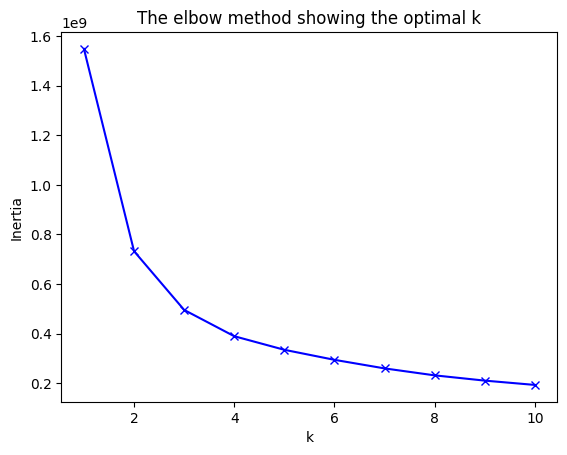

In [77]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')



In [78]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.4385560151920187


Silhouette Score: 0.5212410725329547
Number of clusters identified: 2


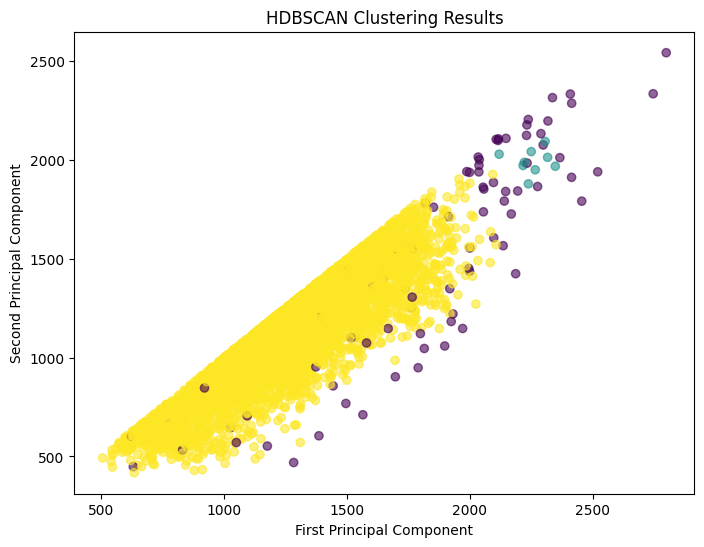

In [79]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train)

# predict clusters
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 1], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



In [80]:
# filter out non-numeric values from the 'monopoly_money_amount' column
fake_transaction['monopoly_money_amount'] = pd.to_numeric(fake_transaction['monopoly_money_amount'], errors='coerce')

fake_transaction.fillna(0)

# group by 'from_totally_fake_account' and 'to_randomly_generated_account' and calculate the sum
agg_result = fake_transaction.groupby(['from_totally_fake_account', 'to_randomly_generated_account'])['monopoly_money_amount'].sum()

# reset the index to make the groupby result a DataFrame
agg_result = agg_result.reset_index()

# create a function to get the top 6 values for each group
def get_top_6(group):
    return group.nlargest(6, 'monopoly_money_amount')

# group by 'from_totally_fake_account' and apply the function to get the top 6 values
top_6_values = agg_result.groupby('from_totally_fake_account').apply(get_top_6)

# reset the index to make 'from_totally_fake_account' a regular column instead of an index
top_6_values.reset_index(drop=True, inplace=True)  # Drop the existing index

top_6_pivot = top_6_values.pivot_table(index='from_totally_fake_account', columns=top_6_values.groupby('from_totally_fake_account').cumcount() + 1, values='monopoly_money_amount')

top_6_pivot.columns = [f'top_{col}' for col in top_6_pivot.columns]

print(top_6_pivot)


                             top_1    top_2    top_3    top_4    top_5  \
from_totally_fake_account                                                
1000.0                     1316.00   850.50   550.00   459.00   441.00   
1002.0                     1489.42  1284.00  1046.50   483.98   458.55   
1006.0                     1610.28  1429.71  1266.98  1206.50   961.00   
1018.0                     1148.00  1038.00   990.00   971.00   962.75   
1053.0                     1723.00  1295.85  1150.00   886.00   838.00   
...                            ...      ...      ...      ...      ...   
100931.0                   2016.59  1751.00  1334.00  1220.18  1209.88   
100934.0                   1906.45  1658.14  1326.50  1231.11  1186.36   
100947.0                   1901.31  1460.90  1411.50  1393.14  1330.50   
100986.0                   1841.74  1520.87  1236.50   915.56   901.50   
100988.0                   1262.41  1167.00   853.00   810.00   722.00   

                             top_6  


In [81]:
X_train, X_test = train_test_split(top_6_pivot, test_size=0.2, random_state=10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

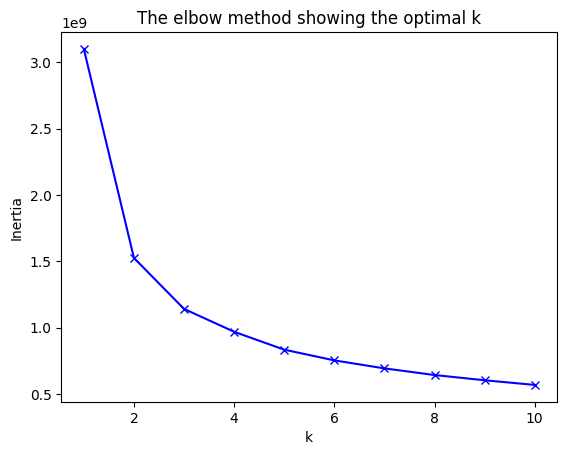

In [82]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')



In [ ]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.4101933537404809


Silhouette Score: 0.47750660220010827
Number of clusters identified: 2


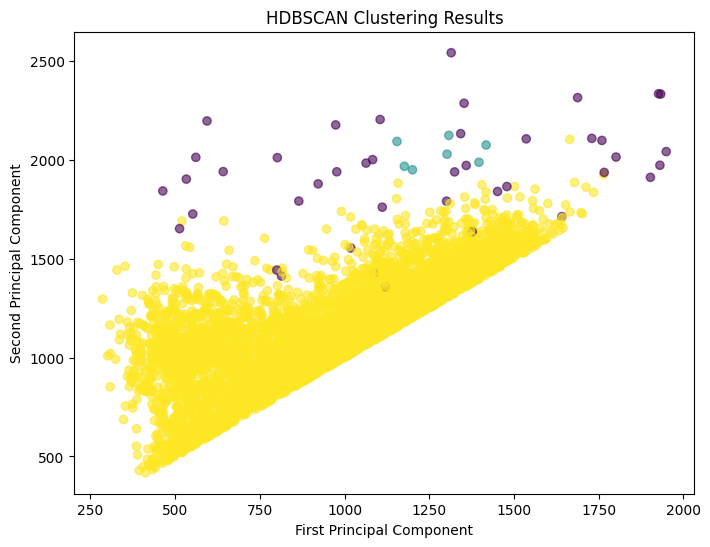

In [83]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train)

# Predict clusters
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)
                                                             
plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 3], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

